In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
def load_data_Urbun(sheet):
    df_urban = {}
    years = ['1400', '1401']
    for year in years:
        file_name = f'U{year}.xlsx'
        sheet_name = f'U{year}{sheet}'
        df = pd.read_excel(file_name, sheet_name = sheet_name)
        df_urban[f'U{year}'] = df
    return df_urban

In [3]:
Urbun_data_income_paid_jobs = load_data_Urbun('P4S01')

Urbun_data_income_freelance_jobs = load_data_Urbun('P4S02')

Urbun_data_income_Miscellaneous = load_data_Urbun('P4S03')

Urbun_data_income_subsidy = load_data_Urbun('P4S04')

#### Group By

In [4]:
Urbun_data_income_freelance_jobs['U1401']['income_s_y'] = Urbun_data_income_freelance_jobs['U1401']['income_s_y'].apply(lambda x : x.strip())

Urbun_data_income_freelance_jobs['U1401']['income_s_y'] = Urbun_data_income_freelance_jobs['U1401']['income_s_y'].apply(lambda x : x if x != '' else '0')

Urbun_data_income_freelance_jobs['U1401']['income_s_y'] = Urbun_data_income_freelance_jobs['U1401']['income_s_y'].astype('float')

In [5]:
Urbun_data_income_Miscellaneous['U1400'].loc[318 , 'income_pension'] = '0'
Urbun_data_income_Miscellaneous['U1400'] = Urbun_data_income_Miscellaneous['U1400'].astype('float')

In [6]:
# Paid Jobs
paid_jobs = {}
for key, value in Urbun_data_income_paid_jobs.items():
    paid_jobs[key] = value.groupby('Address')[['netincome_w_y']].agg('sum').reset_index()
    
# Freelance Jobs
Freelance_Jobs = {}
for key, value in Urbun_data_income_freelance_jobs.items() :
    Freelance_Jobs[key] = value.groupby('Address')[['income_s_y']].agg('sum').reset_index()
    
# Miscellaneous
Miscellaneous = {}
selected_columns = ['income_pension', 'income_rent', 'income_interest', 'income_aid', 'income_resale', 'income_transfer']
for key in Urbun_data_income_Miscellaneous.keys():
    Miscellaneous[key] = Urbun_data_income_Miscellaneous[key].groupby('Address')[selected_columns].agg('sum').reset_index()
    
# Subsidy 
Subsidy = {}
for key, value in Urbun_data_income_subsidy.items():
    Subsidy[key] = value.groupby('Address')[['subsidy']].agg('sum').reset_index()

#### Process Income

In [7]:
def process_income_data_Urbun(years):
    ans = {}
    for year in years :
        
        df = paid_jobs[f'U{year}'].merge(Freelance_Jobs[f'U{year}'], how = 'outer')

        df = df.merge(Miscellaneous[f'U{year}'], how = 'outer')

        df = df.merge(Subsidy[f'U{year}'], how='outer')
        
        ans[f'number{year}'] = df['Address'].nunique()

        df = df.drop(columns='Address')

        df.dropna(how='all', inplace=True)

        df.fillna(0, inplace=True)

        df = df.astype('float')

        df = df.sum(axis=1)
        
        ans[f'{year}'] = df
        
    return ans

In [8]:
years = ['1400', '1401']
Urban_data_income = process_income_data_Urbun(years)

#### تابع حذف داده های پرت

In [9]:
def zscore(data) :
    z_scores = np.abs(stats.zscore(data))
    return data[z_scores < 3]

In [10]:
def IQR(data) :
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

#### برای تحلیل جواب تست اندرسون

In [11]:
def Anderson(result) :
    print(f"Statistic: {result.statistic}")
    print(f"Critical Values: {result.critical_values}")
    print(f"Significance Levels: {result.significance_level}")
    
    for i in range(len(result.critical_values)):
        if result.statistic > result.critical_values[i]:
            print(f"At the {result.significance_level[i]}% significance level, data is NOT normal.")
        else:
            print(f"At the {result.significance_level[i]}% significance level, data is normal.")

### فرضیات

- **H0**: میزان درآمد افراد شهری در سال ۱۴۰۱ نسبت به سال ۱۴۰۰ افزایش یافته است
- **H1**:میزان درآمد افراد شهری در سال ۱۴۰۱ نسبت به سال ۱۴۰۰ کاهش یافته است

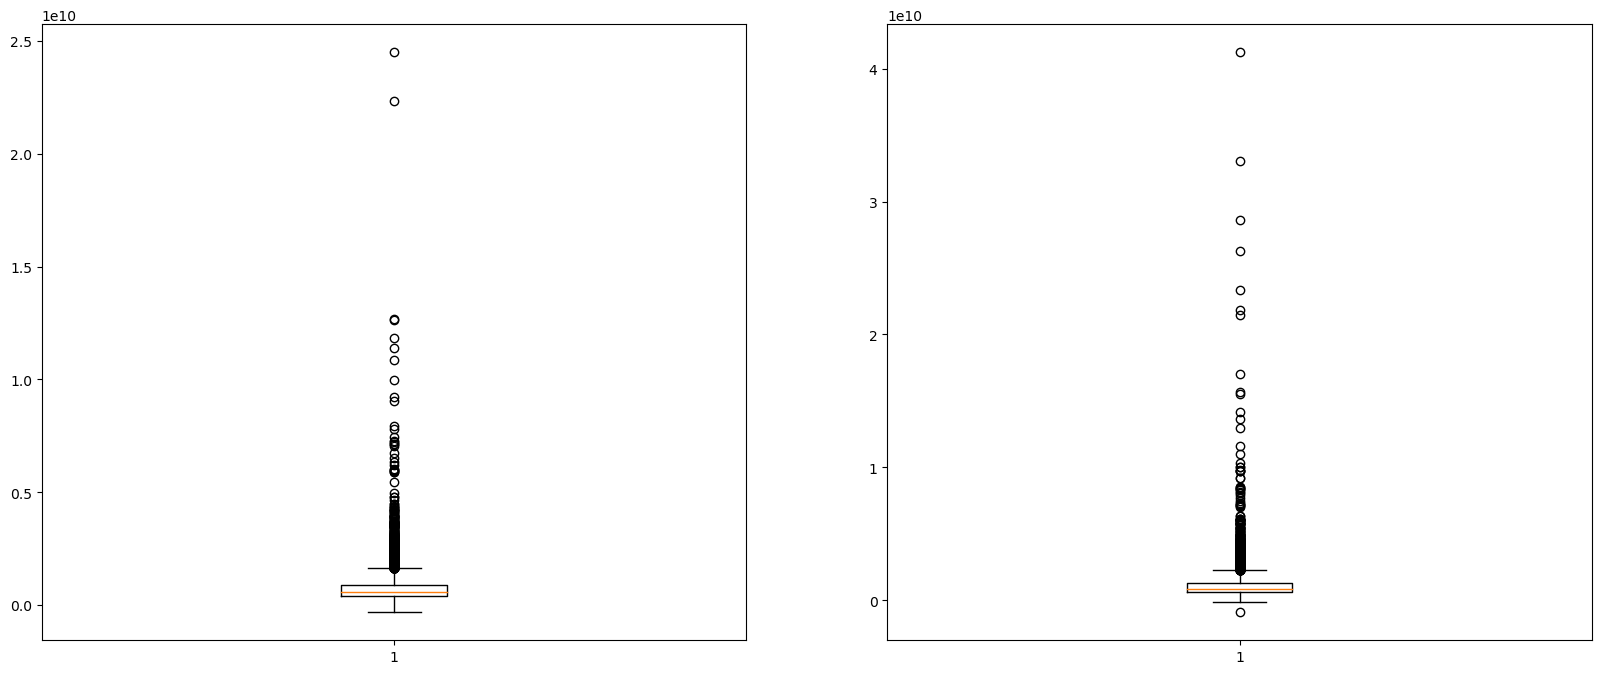

In [12]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.boxplot(Urban_data_income['1400'])
plt.subplot(1,2,2)
plt.boxplot(Urban_data_income['1401'])
plt.show()

In [13]:
Z_1400 = zscore(Urban_data_income['1400'])
Z_1401 = zscore(Urban_data_income['1401'])

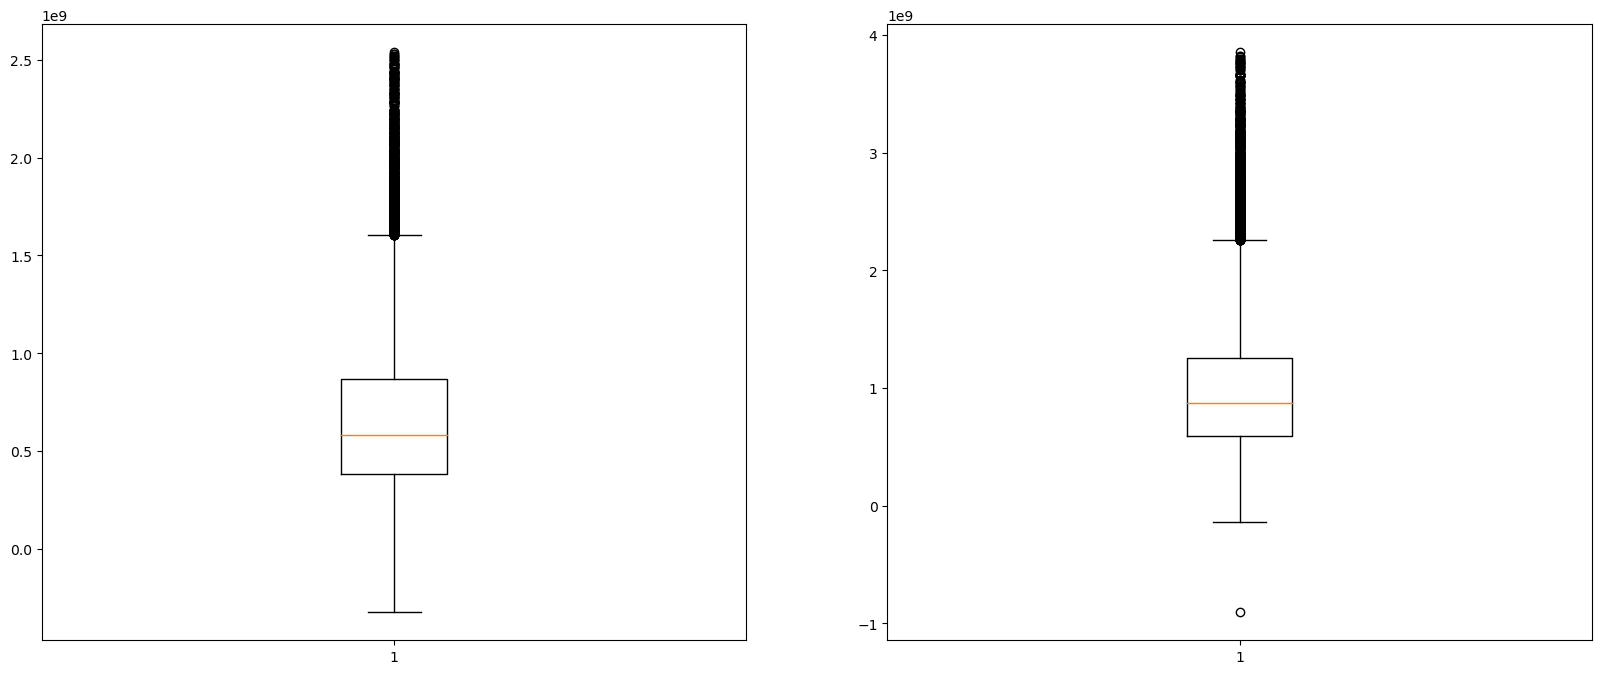

In [14]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.boxplot(Z_1400)
plt.subplot(1,2,2)
plt.boxplot(Z_1401)
plt.show()

In [15]:
anderson_1400_zscore = stats.anderson(Z_1400)
anderson_1401_zscore = stats.anderson(Z_1401)
Anderson(anderson_1400_zscore)
print()
Anderson(anderson_1401_zscore)

Statistic: 374.69584891596605
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 357.6387253724315
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


In [16]:
stats.mannwhitneyu(Z_1400, Z_1401, alternative = 'less')

MannwhitneyuResult(statistic=122944569.5, pvalue=0.0)

#### تلاش برای نرمال سازی

In [17]:
yeojohnson_1400 , _ = stats.yeojohnson(Z_1400)
yeojohnson_1401 , _ = stats.yeojohnson(Z_1401)
anderson_yeojohnson_1400 = stats.anderson(yeojohnson_1400)
anderson_yeojohnson_1401 = stats.anderson(yeojohnson_1401)
Anderson(anderson_yeojohnson_1400)
print()
Anderson(anderson_yeojohnson_1401)

Statistic: 312.36801528023716
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 306.4822430128552
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


In [18]:
log_1400 = np.log(Z_1400)
log_1401 = np.log(Z_1401)

log_1400 = log_1400[~np.isnan(log_1400)]
log_1400 = log_1400[~np.isinf(log_1400)]

log_1401 = log_1401[~np.isnan(log_1401)]
log_1401 = log_1401[~np.isinf(log_1401)]


anderson_log_1400 = stats.anderson(log_1400)
anderson_log_1401 = stats.anderson(log_1401)

Anderson(anderson_log_1400)
print()
Anderson(anderson_log_1401)

Statistic: 300.60288354907607
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 374.65404868982296
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


d:\miniconda3\envs\bootcamp\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\miniconda3\envs\bootcamp\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
sqrt_1400 = np.sqrt(Z_1400)
sqrt_1401 = np.sqrt(Z_1401)

sqrt_1400 = sqrt_1400[~np.isnan(sqrt_1400)]
sqrt_1400 = sqrt_1400[~np.isinf(sqrt_1400)]

sqrt_1401 = sqrt_1401[~np.isnan(sqrt_1401)]
sqrt_1401 = sqrt_1401[~np.isinf(sqrt_1401)]

anderson_sqrt_1400 = stats.anderson(sqrt_1400)
anderson_sqrt_1401 = stats.anderson(sqrt_1401)
Anderson(anderson_sqrt_1400)
print()
Anderson(anderson_sqrt_1401)

Statistic: 35.50543449931138
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 51.1557398812256
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


d:\miniconda3\envs\bootcamp\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### آیا سطح زندگی مردم تغییر کرده

- میام به هرکدوم از ویژگی ها بین 1 که میشه فقیر 2 میشه نرمال و 3 میشه پولدار نمره میدم بعد جمع میکنم اون حمع ها هم تقسیم میکنم به سطح زندگی افراد

In [20]:
living_Data = load_data_Urbun('P2')

In [21]:
living_Data['U1400'][['room', 'space']].corr()

,room,space
room,1.000000,0.814061
space,0.814061,1.000000


In [22]:
def room(x) :
    if x < 3 : 
        return 0
    elif x < 5 :
        return 1
    else :
        return 2

In [23]:
living_Data['U1400']['room_score'] = living_Data['U1400']['room'].apply(lambda x : room(x))
living_Data['U1400'].drop(columns = 'room' ,inplace = True)
living_Data['U1401']['room_score'] = living_Data['U1401']['room'].apply(lambda x : room(x))
living_Data['U1401'].drop(columns = 'room' ,inplace = True)

In [24]:
def tenure(x) :
    if x == 'Service' or x == 'Free' or x == 'Free':
        return 0
    elif x == 'Mortgage' or x == 'Rent' :
        return 1
    else :
        return 2

In [25]:
living_Data['U1400']['tenure_score'] = living_Data['U1400']['tenure'].apply(lambda x : tenure(x))
living_Data['U1400'].drop(columns = 'tenure', inplace = True)

living_Data['U1401']['tenure_score'] = living_Data['U1401']['tenure'].apply(lambda x : tenure(x))
living_Data['U1401'].drop(columns = 'tenure', inplace = True)

In [26]:
def space(x) :
    if x < 70 :
        return 0
    elif x <= 130 :
        return 1
    else :
        return 2

In [27]:
living_Data['U1400']['space_score'] = living_Data['U1400']['space'].apply(lambda x : space(x))
living_Data['U1400'].drop(columns = 'space', inplace = True)

living_Data['U1401']['space_score'] = living_Data['U1401']['space'].apply(lambda x : space(x))
living_Data['U1401'].drop(columns = 'space', inplace = True)

In [28]:
living_Data['U1400'].drop(columns = 'material', inplace = True)
living_Data['U1401'].drop(columns = 'material', inplace = True)

In [29]:
living_Data['U1400'].drop(columns = 'construction', inplace = True)
living_Data['U1401'].drop(columns = 'construction', inplace = True)

In [30]:
def TF(x) :
    if x :
        return 1
    else :
        return 0

In [31]:
List = ['vehicle', 'motorcycle', 'bicycle', 'radio', 'radiotape',
       'TVbw', 'TV', 'VHS_VCD_DVD', 'computer', 'cellphone', 'freezer',
       'refridgerator', 'fridge', 'stove', 'vacuum', 'washingmachine',
       'sewingmachine', 'fan', 'evapcoolingportable', 'splitportable',
       'dishwasher', 'microwave', 'none', 'pipewater', 'electricity',
       'pipegas', 'telephone', 'internet', 'bathroom', 'kitchen',
       'evapcooling', 'centralcooling', 'centralheating', 'package', 'split',
       'wastewater']

In [32]:
for item in List :
    living_Data['U1400'][item] = living_Data['U1400'][item].apply(lambda x : TF(x))
    living_Data['U1401'][item] = living_Data['U1401'][item].apply(lambda x : TF(x))

In [33]:
def cookingfuel(x) :
    if x == 'LiquidGas' or x == 'Gasoline' or x == 'Oil' :
        return 0
    else :
        return 1

In [34]:
living_Data['U1400']['cookingfuel'] = living_Data['U1400']['cookingfuel'].apply(lambda x : cookingfuel(x))
living_Data['U1401']['cookingfuel'] = living_Data['U1401']['cookingfuel'].apply(lambda x : cookingfuel(x))

In [35]:
def heatingfuel(x):
    if x == 'NaturalGas' or x == 'Electricity':
        return 1
    else :
        return 0

In [36]:
living_Data['U1400']['heatingfuel'] = living_Data['U1400']['heatingfuel'].apply(lambda x : heatingfuel(x))
living_Data['U1401']['heatingfuel'] = living_Data['U1401']['heatingfuel'].apply(lambda x : heatingfuel(x))

In [37]:
living_Data['U1400']['waterheatingfuel'] = living_Data['U1400']['waterheatingfuel'].apply(lambda x : heatingfuel(x))
living_Data['U1401']['waterheatingfuel'] = living_Data['U1401']['waterheatingfuel'].apply(lambda x : heatingfuel(x))

In [38]:
living_Data['U1400'].drop(columns = 'Address', inplace = True)
living_Data['U1401'].drop(columns = 'Address', inplace = True)

In [62]:
score_1400 = living_Data['U1400'].sum(axis = 1)
score_1401 = living_Data['U1401'].sum(axis = 1)

In [65]:
def change_score(x) :
    if x <= 15 :
        return 'Poor'
    elif x < 25 :
        return 'Normal'
    else :
        return 'Rich'

In [66]:
score_1400 = score_1400.apply(lambda x : change_score(x))
score_1401 = score_1401.apply(lambda x : change_score(x))

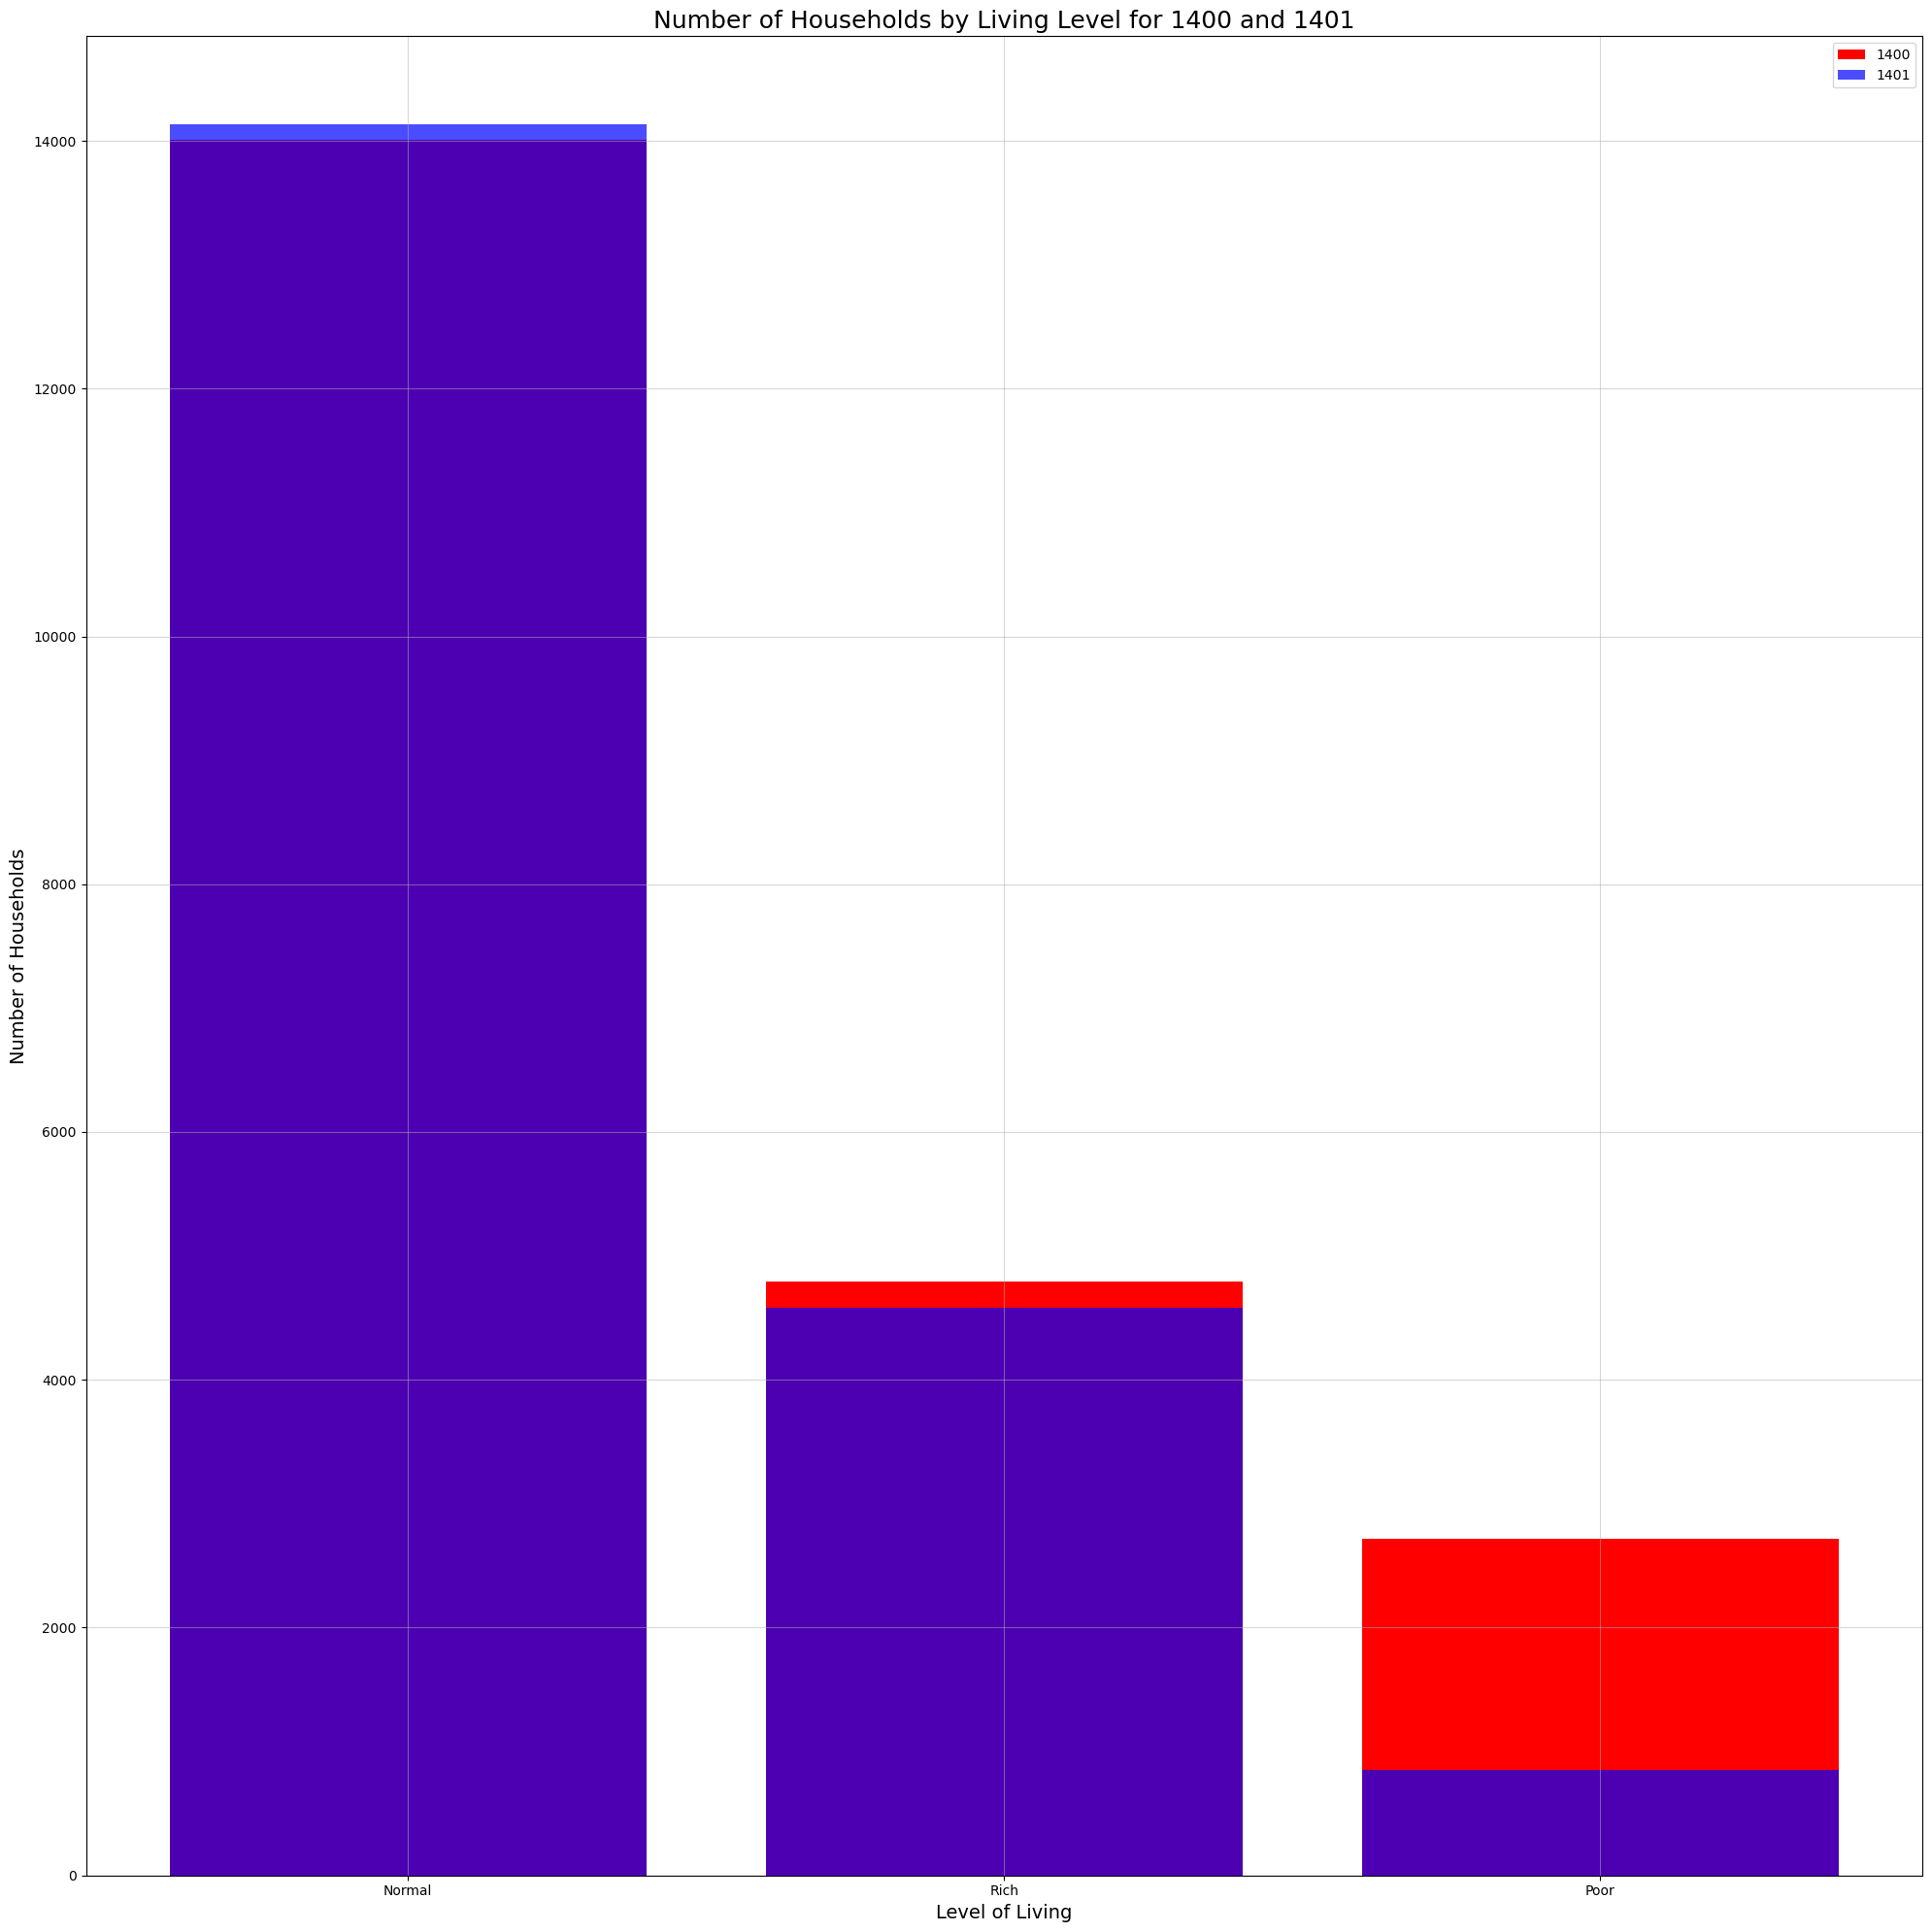

In [67]:
plt.figure(figsize=(20 , 20))
plt.bar(['Normal', 'Rich', 'Poor'], score_1400.value_counts(), color='r', label = 1400)
plt.grid(True, alpha = 0.5)
plt.bar(['Normal', 'Rich', 'Poor'], score_1401.value_counts(),  color='b', alpha = 0.7, label = 1401)
plt.grid(True, alpha = 0.5)
plt.xlabel('Level of Living', fontsize=14)
plt.ylabel('Number of Households', fontsize=14)
plt.title('Number of Households by Living Level for 1400 and 1401', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()

طبق نمودار میشه فهمید با اینکه درآمد در طول 2 سال تغییر چشم گیری نداشته توقع داشتیم که حداقل افراد در همون سطح بمونن ولی افراد فقیر که خیلی کم شدن ولی افراد پولدار یکم کمتر شدن
پس میشه گفت که رفاه زندگی شون بیشتر شده

ولی نمیشه بگیم با توجه به نمودار پس یه ازمون فرض هم میریم

In [68]:
scores = pd.DataFrame({1400 : score_1400.value_counts(), 1401 : score_1401.value_counts()})
scores

,1400,1401
Normal,14007,14137
Rich,4795,4580
Poor,2714,850


In [69]:
stats.chi2_contingency(scores)

Chi2ContingencyResult(statistic=889.9591145455377, pvalue=5.595433216987462e-194, dof=2, expected_freq=array([[14739.58337999, 13404.41662001],
       [ 4909.87756493,  4465.12243507],
       [ 1866.53905508,  1697.46094492]]))

- **H0**: توزیع مقادیر در دو گروه مشابه است
- **H1**: توزیع مقادیر در دو گروه مشابه نیست

#### تحلیل نتایج آزمون کای-اسکور

##### p-value بسیار کم:

p-value به‌دست‌آمده (5.60 × 10^-194) بسیار کمتر از سطح معنی‌داری معمولی (مثلاً 0.05) است. این به این معنی است که شواهد قوی وجود دارد که نشان می‌دهد توزیع مقادیر (poor، normal، rich) در دو گروه با یکدیگر متفاوت است.

##### آمار کای-اسکور بالا:

مقدار کای-اسکور بالا (889.96) نشان‌دهنده تفاوت‌های قابل توجه بین توزیع‌های مشاهده‌شده و توزیع‌های مورد انتظار است.


پس همونطور که گفتیم با اینکه درامد تغییر معناداری نکرده ولی سطح زندگی فرق کرده